# 학습목표 : 웹에서 받은 이미지를 기존의 모델이 잘 분류하는지 확인하기

flickerapi : 잘못 tag된 데이터를 없애야 한다.  사람들이 제대로 tag 안한다...
#### extras : 받고 싶은 사이즈를 comma를 이용해서 모두 작성하면, 해당 사이즈 다 받아옴

In [0]:
pip install flickrapi

     |████████████████████████████████| 61kB 4.7MB/s 


In [0]:
from flickrapi import FlickrAPI

FLICKER_KEY = '505e8c2b05e8b5aa51766a43fc4bc7a7'
FLICKER_SECRET = '46b3ef2f43b04ac6'

flickr = FlickrAPI(FLICKER_KEY, FLICKER_SECRET , format='parsed-json')
extras = 'url_m'

cats = flickr.photos.search(text='kitten', per_page=10, extras=extras)
photos = cats['photos']

from pprint import pprint
pprint(photos)

{'page': 1,
 'pages': 16675,
 'perpage': 10,
 'photo': [{'farm': 66,
            'height_m': '500',
            'id': '48241761916',
            'isfamily': 0,
            'isfriend': 0,
            'ispublic': 1,
            'owner': '142178697@N05',
            'secret': '31e5e9ac82',
            'server': '65535',
            'title': 'KuroMika 3538.jpg',
            'url_m': 'https://live.staticflickr.com/65535/48241761916_31e5e9ac82.jpg',
            'width_m': '333'},
           {'farm': 66,
            'height_m': '333',
            'id': '48241777727',
            'isfamily': 0,
            'isfriend': 0,
            'ispublic': 1,
            'owner': '35596011@N08',
            'secret': '6d6808edb3',
            'server': '65535',
            'title': 'Crystal Kitty',
            'url_m': 'https://live.staticflickr.com/65535/48241777727_6d6808edb3.jpg',
            'width_m': '500'},
           {'farm': 66,
            'height_m': '333',
            'id': '48241357381',
    

In [0]:
import numpy as np
import urllib.request
import cv2

def url_to_image(url):
  with urllib.request.urlopen(url) as resp:
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    # 8 byte 단위로 읽어옴 B, G, R, B, G, R...
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

In [0]:
import numpy
from google.colab.patches import cv2_imshow

urls = [photo['url_m'] for photo in photos['photo']]
images_list = [url_to_image(url) for url in urls]
resized_images = np.asarray([cv2.resize(img, (224,224)) for img in images_list])

for url in urls:
  print("downloading %s\n\n" % (url))
  image = url_to_image(url)
  cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def image_resize(image, x, y):
  return cv2.resize(image, (x,y))
# resize 사용하는 이유
# 1. 잘못된 사이즈가 올 수 있어서 resize해줘야 한다.
# 2. 이미 학습된 네트워크가 다른 input을 요구할 수 있기 때문에 resize를 사용하는 경우가 

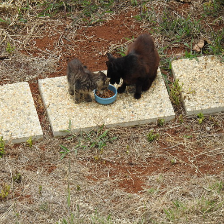

(224, 224, 3)


In [0]:
image_temp = images_list[9].copy()
resized = image_resize(image_temp, 224, 224)
cv2_imshow(resized)
print(resized.shape)

In [0]:
# batch에서 사용하기 위해서 차원 확장시킴
# (None, 784) 에서 None은 batch숫자를 가리킴
# (None, 784) * (784, 128)

resized = np.expand_dims(resized, axis=0)
print(resized.shape)

(1, 224, 224, 3)


In [0]:
def image_array(num_images):
  images = []
  
  for i in range(num_images):
    image_original_url = photos['photo'][i]['url_m']
    image = url_to_image(image_original_url)
    resized_image = cv2.resize(image, (224,224))
    cv2_imshow(resized_image)
    images.append(resized_image)
  
  return np.asarray(images)

In [0]:
resized_image = image_array(10)
# np.asarray() : list를 numpy array로 바꿔줌

# VGG는 feature layer가 feature를 잘 잡아내니까 feature layer를 가져다 쓴다.  
# fully connected layer만 우리 가 새로 만들어서 우리만의 문제를 해결할 수 있다.
# feature extractor & classification layer == VGG 구성

In [0]:
from keras.applications.vgg16 import VGG16
model = VGG16()

[What is the meaning of the “None” in model.summary of KERAS?](https://stackoverflow.com/questions/47240348/what-is-the-meaning-of-the-none-in-model-summary-of-keras)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
#yhat = model.predict(resized_image[3][np.newaxis])
yhat = model.predict(resized)

In [0]:
yhat

In [0]:
from keras.applications.vgg16 import decode_predictions
label = decode_predictions(yhat)
# label = label[0][0]
print(label[1])
print(label[2] * 100)

bison
27.495643496513367
